# Simpsons Classifier


## Images with different sizes: understanding _Spatial Pyramid Pooling_

If the neural network has a fixed size as input images we'll have to deal with it. 

So the possible solutions will be:

* Crop: problem, there is information that gets lost.
* Warp/Resize: problem, the image patterns change and we lose accuracy.
* Padding: problem, the model might be biased to images that contain such a padded border.
* Combination of previous.

Spatial Pyramid Pooling tries to resolve it. Indeed it should improve the efficiency.

Paper: https://arxiv.org/abs/1406.4729

## Defining Datasets

In [1]:
#Import libraries
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
from random import shuffle

In [2]:
#Initial data inside simpsons.tar.gz
info = pd.read_csv('./the-simpsons-characters-dataset/number_pic_char.csv')
print(info)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [6]:
def get_character_directories(path):
    character_directories = os.listdir(path)
    if '.DS_Store' in character_directories: character_directories.remove('.DS_Store')
    return character_directories

def get_images_from_directory(path):
    image_files = os.listdir(path)
    if '.DS_Store' in image_files: image_files.remove('.DS_Store')
    return image_files

In [7]:
#root pats
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"

#train directories
character_directories = get_character_directories(train_root_path)

In [8]:
def test_paths():
    #configure train dataset
    print("Train: {}".format(character_directories[:5]))

    #images from one train directory
    character_path = train_root_path + "/" + character_directories[1]
    train_image_names = get_images_from_directory(character_path)
    print("Images of {}: {}".format(character_directories[1], train_image_names[:5]))


    #configure test dataset
    test_image_names = get_images_from_directory(test_root_path)
    print("\nTest: {}".format(test_image_names[:5]))

test_paths()

Train: ['maggie_simpson', 'charles_montgomery_burns', 'patty_bouvier', 'ralph_wiggum', 'chief_wiggum']
Images of charles_montgomery_burns: ['pic_0982.jpg', 'pic_0028.jpg', 'pic_0996.jpg', 'pic_0766.jpg', 'pic_0000.jpg']

Test: ['principal_skinner_34.jpg', 'apu_nahasapeemapetilon_28.jpg', 'abraham_grampa_simpson_41.jpg', 'principal_skinner_20.jpg', 'apu_nahasapeemapetilon_14.jpg']


### Showing a train and test samples

Label:lenny_leonard, Image:9, Shape:(352, 320, 3)


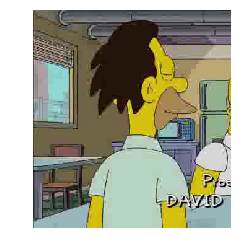

In [9]:
def show_train_image(character_directory, idx):
    directory = os.path.join(train_root_path, character_directory)
    sample_file = get_images_from_directory(directory)[idx]
    path_file = os.path.join(directory, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format(character_directory, idx, sample_image.shape))
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()
    
idx = random.randint(0, 10)
show_train_image(character_directories[idx], idx)

Label:sideshow_bob, Image:8, Shape:(171, 229, 3)


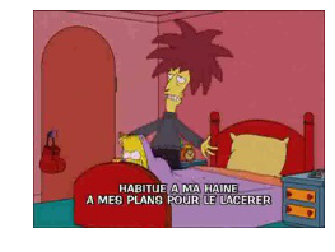

In [10]:
def show_test_image(idx):
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()

idx = random.randint(0, 10)
show_test_image(idx)

### Training Images

In [11]:
'''
input 'different_characters' will define the number of different Simpson
characters the generator is going to return
'''
#Create the batch generator
def training_images_batch_generator(batch_size, different_characters, verbose=False):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    characters = characters.map(lambda x: x.replace(" ", "_").lower()).tolist()

    image_files = list()
    for i in range(0, different_characters):
        directory = os.path.join(train_root_path, characters[i])
        image_files += list(map(lambda x: os.path.join(directory, x), get_images_from_directory(directory)))

    #shuffle all the images
    shuffle(image_files)
    
    #getting an number of complete chunks according to the batch size
    number_complete_chunks = len(image_files)//batch_size
    num_images_in_all_chunks = number_complete_chunks * batch_size
        
    for b in range(0, num_images_in_all_chunks, batch_size):
        if verbose:
            print("init: {}, end:{}".format(b, b+batch_size))
            
        yield image_files[b:b + batch_size]

In [12]:
#testing the generator
for batch in training_images_batch_generator(3200, 20, True):
    pass

init: 0, end:3200
init: 3200, end:6400
init: 6400, end:9600
init: 9600, end:12800
init: 12800, end:16000
init: 16000, end:19200


## Keras + SPP Module

Keras doesn't support currently the SSP layer but thanks to [yhenon](https://github.com/yhenon) there's a module which is integrated into keras. [Code is here](https://github.com/yhenon/keras-spp)

In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Convolution2D, Activation, MaxPooling2D, Dense
from spp.SpatialPyramidPooling import SpatialPyramidPooling

Using TensorFlow backend.


In [14]:
batch_size = 64
num_channels = 3
num_classes = 10 #different number of Simpons characters

In [15]:
'''
Typical network architecture is tried out
'''
model = Sequential()

#Note that we leave the image size as None to allow multiple image sizes
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(num_channels, None, None)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(SpatialPyramidPooling([1, 2, 4]))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [16]:
#TESTING
# train on images with different sizes
model.fit(np.random.rand(batch_size, num_channels, 8, 9), np.zeros((batch_size, num_classes)))
model.fit(np.random.rand(batch_size, num_channels, 20, 13), np.zeros((batch_size, num_classes)))

Epoch 1/10
64/64 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 8/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 10/10
64/64 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 1/10
64/64 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epo